This section is used to fill in empty or inconsistent value for better understanding of data <br>
<b><font size=7>Table of content</font></b><br>
<font size=3.5>
2. [Data preparation & exploration](#2)<br>
&emsp;2.1. [Weather data exploration](#2.1)<br>
&emsp;&ensp;a. [Temperature](#2.1.a)<br>
&emsp;&ensp;b. [Wind speed](#2.2.a)<br>
&emsp;2.2. [Modeling input preprocessing](#2.2)<br>
&emsp;&emsp;2.2.1. [VietNam data](#2.2.1)<br>
&emsp;&emsp;&emsp;2.2.1.1. [By country grand total](#2.2.1.1)<br>
&emsp;&emsp;&emsp;&ensp;a. [Processing raw data](#2.2.1.1.a)<br>
&emsp;&emsp;&emsp;&ensp;b. [Processing vaccine data](#2.2.1.1.b)<br>
&emsp;&emsp;&emsp;&ensp;c. [Processing modeling data](#2.2.1.1.c)<br>
&emsp;&emsp;&emsp;2.2.1.2. [By each province](#2.2.1.2)<br>
&emsp;&emsp;&emsp;&ensp;a. [Processing raw data](#2.2.1.2.a)<br>
&emsp;&emsp;&emsp;&ensp;b. [Processing vaccine data](#2.2.1.2.b)<br>
&emsp;&emsp;&emsp;&ensp;c. [Processing modeling data](#2.2.1.2.c)<br>
&emsp;&emsp;2.2.2. [World data](#2.2.2)<br>
&emsp;&emsp;&emsp;2.2.2.1. [By each country](#2.2.2.1)<br>
&emsp;&emsp;&emsp;&ensp;a. [Processing raw data](#2.2.2.1.a)<br>
&emsp;&emsp;&emsp;&ensp;b. [Processing vaccine data](#2.2.2.1.b)<br>
&emsp;&emsp;&emsp;&ensp;c. [Processing modeling data](#2.2.2.1.c)<br>
&emsp;&emsp;&emsp;2.2.2.2. [By world grand total](#2.2.2.2)<br>
&emsp;&emsp;&emsp;&ensp;a. [Processing raw data](#2.2.2.2.a)<br>
&emsp;&emsp;&emsp;&ensp;b. [Processing vaccine data](#2.2.2.2.b)<br>
&emsp;&emsp;&emsp;&ensp;c. [Processing modeling data](#2.2.2.2.c)<br>    
</font>

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import re,os,time
import numpy as np
import traceback
from functools import partial
from multiprocessing import Manager,Pool
from covid_science.collection import message_box
from covid_science.preparation import read_stored_data,process_raw_infect_data,vaccinated_case
from covid_science.c_preparation import model_initial,model_parameter
from covid_science.modeling import fill_empty_param,reproduction_number
from covid_science.utility_func import trim_mean
from covid_science.workers import raw_wrapper_func,vaccine_wrapper_func

<font size=10>**2.Data preparation & exploration**</font><a name="2"></a><br>
<ins><font size=6>**2.1.Weather data exploration**</font></ins><a name="2.1"></a>

<font size=4><ins>**a. Temperature**</ins></font><a name="2.1.a"></a><br>
* <ins>Processing</ins>

In [ ]:
temp_df = pd.read_csv("database/Covid-19_raw_data/robust_weather_condition/average_temperature.csv")
temp_df = temp_df.groupby(['iso_code','Country']).mean().loc[:,'Jan':'Dec']
temp_df = temp_df.reset_index()
idx = pd.MultiIndex.from_product([temp_df.iso_code, range(1,13)],names=['iso_code','month'])
temp_df = pd.DataFrame({"temperature":temp_df.loc[:,"Jan":].to_numpy().flatten()},index=idx)
temp_df.reset_index(inplace=True)
temp_df.sort_values(['iso_code','month'],inplace=True)
temp_df.head(3)

In [ ]:
df_raw = pd.read_csv("database/Covid-19_raw_data/OurWorldinData/covid_data_simplified.csv",usecols=['iso_code','date','new_cases','population'],parse_dates=["date"])
df_raw['case_per_1mil']=df_raw.new_cases/(df_raw.population/1000000)
df_raw.insert(2,'month',df_raw.date.dt.month)

temp_df_processed = df_raw.groupby(['iso_code','month'])[['case_per_1mil']].mean()
temp_df_processed = temp_df_processed.reset_index()
temp_df_processed.sort_values(['iso_code','month'],inplace=True)
temp_df_processed = temp_df_processed.merge(temp_df,on=['iso_code','month'])
temp_df_processed.dropna(subset=['case_per_1mil','temperature'],inplace=True)
temp_df_processed.head(3)

* <ins>Correlation</ins>

In [ ]:
coef, p_value = stats.pearsonr(temp_df_processed.case_per_1mil,temp_df_processed.temperature)
print("The Pearson Correlation Coefficient between case_per_1mil and temperature is: {}, with a P-value of: {}.".format(coef,p_value))
coef, p_value = stats.spearmanr(temp_df_processed.case_per_1mil,temp_df_processed.temperature)
print("The Spearmanr Correlation Coefficient between case_per_1mil and temperature is: {}, with a P-value of: {}.".format(coef,p_value))

<font size=4><ins>**b. Wind speed**</ins></font><a name="2.2.a"></a><br>
* <ins>Processing</ins>

In [ ]:
country_code = pd.read_excel('https://population.un.org/wpp/Download/Files/4_Metadata/WPP2022_F01_LOCATIONS.XLSX',usecols=[4,5],header=16)\
.rename(columns={"ISO3 Alpha-code":"iso_code","ISO2 Alpha-code":"iso2_code"})

In [ ]:
wind_df = pd.read_csv("database/Covid-19_raw_data/robust_weather_condition/average_wind_speed.csv",usecols=[0,2,3]).rename(columns={"Country or Territory Code":"iso2_code",
                                                                                                                          "Annual NCDC Computed Value":"wind_speed"})
wind_df = wind_df.merge(country_code,on='iso2_code')
wind_df.head(3)

In [ ]:
wind_df_processed = temp_df_processed.groupby("iso_code").mean()[['case_per_1mil']].reset_index()
wind_df_processed = wind_df_processed.merge(wind_df,on='iso_code')
wind_df_processed.head(3)

* <ins>Corellation</ins>

In [ ]:
coef, p_value = stats.pearsonr(wind_df_processed.case_per_1mil,wind_df_processed.wind_speed)
print("The Pearson Correlation Coefficient between case_per_1mil and wind speed is: {}, with a P-value of: {}.".format(coef,p_value))
coef, p_value = stats.spearmanr(wind_df_processed.case_per_1mil,wind_df_processed.wind_speed)
print("The Spearmanr Correlation Coefficient between case_per_1mil and wind speed is: {}, with a P-value of: {}.".format(coef,p_value))

<font size=4><ins>**Conclusion**</ins></font><br>
Both wind speed and environment temperature has small correlation to the transmission rate of covid-19, so they can't be used as main indicator to model covid-19 tranmission. But we can derive the following conclusions from data exploration:

* With the increase of environment temperature, transmission rate tends to decrease.
* With the increase of wind speed, transmission rate tends to increase.

**Note:** These are only the conclusions after robust exploration, it can change after that.

<ins><font size=6>**2.2.Modeling input preprocessing**</font></ins><a name="2.2"></a><br>
<ins><font size=5>**2.2.1.VietNam data**</font></ins><a name="2.2.1"></a><br>
<ins><font size=4>**2.2.1.1. By country grand total**</font></ins><a name="2.2.1.1"></a><br>

In [ ]:
df_vn_population = pd.read_csv("database/Covid-19_raw_data/VietNamData/vietnam_population.csv",index_col=[0,1])
df_vn_population.loc[2019].sum(axis=1)

In [ ]:
#slice raw data of death, infect case
df_vn = read_stored_data("database/Covid-19_raw_data/VietNamData/Ministry_of_Health_data/total_case",parse_dates=["date"])
df_vn_slice = df_vn.loc[df_vn.code =="local_case"].copy()
df_vn_slice.drop(axis=1,columns=['case_origin','code'],inplace=True)

df_vn_death = read_stored_data("database/Covid-19_raw_data/VietNamData/Ministry_of_Health_data/death_data",parse_dates=["date"])
df_vn_death = df_vn_death[["date","VN_death_case"]]

#merge DataFrame
df_vn_slice = df_vn_slice.merge(df_vn_death,on="date")

<font size=4><ins>**a. Processing raw data**</ins></font><a name="2.2.1.1.a"></a><br>
* <ins>Raw general input parameters</ins>

In [ ]:
vn_raw_rolling = 10
vn_trim_percent = 25
vn_death_distribution = [0.4,0.3,0.2,0.025,0.025,0.025,0.025]
vn_death_after = 4
vn_death_rolling = 14
vn_use_origin = True
vn_recovery_distribution = [0.3,0.5,0.1,0.05,0.05]
vn_recovery_after = 7

#birth rate -- data from United Nations-Department of Economic and Social Affairs Population Division with average 2019-2021
vn_birth_rate = (1+(15.357/1000))**(1/365)-1 #(convert to %/day)
#death rate -- data from United Nations-Department of Economic and Social Affairs Population Division with average 2019-2021
vn_death_rate = (1+(6.73/1000))**(1/365)-1 #(convert to %/day)

# zero for fast data processing, ignore randomness
vn_raw_method_limit=0 
vn_raw_seed = 1

* <ins>Groups of function input parameters</ins>

In [ ]:
#all shouldn't be modified

#living population which affected by the disease at the chosen starting time
vn_population = int(df_vn_population.loc[2019].sum(axis=1)['Average population(thousand)'])*1000

vn_col = ['case','VN_death_case']
vn_window_trim = [('case_avg',vn_raw_rolling,vn_trim_percent),('death_avg',vn_raw_rolling,vn_trim_percent)]
vn_date = ['date',None]
vn_death_input = ('death_avg','case_avg','origin_case',vn_death_distribution,{'death_after':vn_death_after})
vn_death_per = ('origin_case','case_avg','death_percent',vn_death_rolling,vn_trim_percent)
vn_recov_input = ('case_avg','recovery_case',vn_use_origin,vn_recovery_distribution,{'recovery_after':vn_recovery_after})
vn_total_N = (vn_population,vn_birth_rate,vn_death_rate,'current_pol_N') 

* <ins>Processing</ins>

In [ ]:
processed_df_vn = df_vn_slice.copy()
processed_df_vn = process_raw_infect_data(processed_df_vn,
                                          vn_col,
                                          vn_window_trim,
                                          vn_date,
                                          vn_death_input,
                                          vn_death_per,
                                          vn_recov_input,
                                          vn_total_N,
                                          method_limit=vn_raw_method_limit,
                                          seed=vn_raw_seed)
processed_df_vn = processed_df_vn.iloc[vn_raw_rolling-1:].reset_index(drop=True).copy() #drop ['case_avg','death_avg'] NaN rows
processed_df_vn.head(3)

<font size=4><ins>**b. Processing vaccine data**</ins></font><a name="2.2.1.1.b"></a><br>
* <ins>Combine vaccination data</ins>

In [ ]:
#VN vaccination data
df_vn_vaccine = pd.read_csv("database/Covid-19_raw_data/OurWorldinData/vietnam_vaccine.csv",parse_dates=["date"])
df_vn_vaccine['new_vaccinations_smoothed'] = df_vn_vaccine['new_vaccinations_smoothed'].interpolate(method="linear",limit_direction='forward').fillna(0)
df_vn_vaccine['new_vaccinations_smoothed']=df_vn_vaccine['new_vaccinations_smoothed'].astype(np.int64)

#merge df
processed_df_vn = processed_df_vn.merge(df_vn_vaccine,on="date")

* <ins>Vaccination references:</ins> <br>
    * https://moh.gov.vn/tin-lien-quan/-/asset_publisher/vjYyM7O9aWnX/content/-infographic-toan-bo-thong-tin-ve-8-loai-vaccine-covid-19-a-uoc-viet-nam-cap-phep-su-dung <br>
    * https://moh.gov.vn/tin-lien-quan/-/asset_publisher/vjYyM7O9aWnX/content/-infographic-toan-bo-thong-tin-can-biet-ve-cac-loai-vaccine-covid-19-viet-nam-ang-tiem <br>
    * https://hcdc.vn/public/img/02bf8460bf0d6384849ca010eda38cf8e9dbc4c7/images/mod1/images/tong-hop-tai-lieu-vac-xin-phong-covid19/files/Thong%20tin%20can%20biet%20ve%20vac-xin%20phong%20COVID-19%20Vero%20Cell.pdf <br>
    * https://vnvc.vn/sinopharm/ <br>
* <ins>Vaccine general input parameters</ins>

In [ ]:
vn_base_vaccine_percent = [1,1,1]
vn_vaccine_info = (["Non Replicating Viral Vector",56,14,14,150,150],
                  ["RNA",28,14,14,150,150],
                  ["Inactivated",28,14,14,150,150])
vn_target_priority=None
vn_meta_df = pd.read_csv("database/Covid-19_raw_data/WHO/vaccine_meta.csv",encoding='utf-8',parse_dates=['START_DATE'])
vn_check_dict = (vn_meta_df.loc[vn_meta_df.ISO3=='VNM']
                  .set_index("PRODUCT_NAME")[['START_DATE']]
                  .to_dict()['START_DATE'])
vn_vac_weight = {'Vaxzevria':(0,28),
                'Gam-Covid-Vac':(0,0.7),
                'CIGB-66':(0,2.2),
                'Comirnaty':(1,40),
                'Spikevax':(1,6),
                'BBIBP-CorV':(2,22.6)}
vn_other_vaccine_weight = (0,0.5)
# zero for fast data processing, ignore randomness
vn_vac_method_limit = 0 
vn_vac_seed = 1

* <ins>Processing</ins>

In [ ]:
vac_distribute = vaccinated_case(vn_base_vaccine_percent,
                                 vn_vaccine_info,
                                 processed_df_vn.shape[0],
                                 vn_target_priority)
vac_distribute.estimate_vac_percent(processed_df_vn.date[0],vn_vac_weight,vn_check_dict,vn_other_vaccine_weight)
vac_distribute.calculate_vaccine_distribution(processed_df_vn,
                                              'new_vaccinations_smoothed',
                                              method_limit=vn_vac_method_limit,
                                              seed=vn_vac_seed)
processed_df_vn.loc[:,'curr_full_vaccinated']=vac_distribute.full_immu_matrix.sum(axis=1)
processed_df_vn.loc[:,'new_full_vaccinated']=vac_distribute.new_full_matrix.sum(axis=1)
processed_df_vn.loc[:,'new_boost_req']=vac_distribute.new_req_boost_matrix.sum(axis=1)

* <ins>Store processed raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/VietNamData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
processed_df_vn.to_csv(folder_path +"/"+"vn_processed_data.csv",encoding="utf-8",index=False)
processed_df_vn.head(3)

<font size=4><ins>**c. Processing modeling data**</ins></font><a name="2.2.1.1.c"></a><br>
* <ins>Modeling general input parameters</ins>

In [ ]:
vn_r_protect_time  = 150
vn_s_vac_ratio = 3.0
vn_avg_infect_t=1
vn_avg_death_t=1
vn_avg_recov_t=1
vn_avg_rotate=1

#fill empty parameters
vn_avg_data=14
vn_weights=2
vn_include_zero=False

#reproduction number parameters
vn_p = 1.0
vn_n = 30
vn_trim = 25

* <ins>Processing</ins>

In [ ]:
model_input_df_vn = processed_df_vn.copy()

total_time_start=time.time()
#round up average case value
model_input_df_vn.iloc[:,[3,4]]=model_input_df_vn.iloc[:,[3,4]].apply(np.round)
model_input_df_vn[['S0','V0','I0','D0','daily_case_non_vaccinated','daily_case_vaccinated']] = model_initial(model_input_df_vn[['case_avg','recovery_case','death_avg',
                                                                                                                                'curr_full_vaccinated','current_pol_N']].to_numpy(),
                                                                                                             vn_r_protect_time,
                                                                                                             vn_s_vac_ratio)
model_input_df_vn[['beta','beta_v','gamma','theta','alpha','alpha0']] = model_parameter(model_input_df_vn[['S0','V0','I0','death_avg','recovery_case','new_full_vaccinated',
                                                                                                           'new_boost_req','daily_case_non_vaccinated','daily_case_vaccinated',
                                                                                                           'current_pol_N']].to_numpy(),
                                                                                        vn_r_protect_time,
                                                                                        vn_avg_infect_t,vn_avg_death_t,vn_avg_recov_t,vn_avg_rotate)
model_df_vn = model_input_df_vn[['date','S0','V0','I0','D0','beta','beta_v','gamma','theta','alpha','alpha0',
                                 'death_avg','recovery_case','new_full_vaccinated','new_boost_req',
                                 'daily_case_non_vaccinated','daily_case_vaccinated','current_pol_N']].copy()
model_df_vn[['S0','V0','I0','D0']]=model_df_vn[['S0','V0','I0','D0']].astype(np.int64)

#add daily recruitment rate
model_df_vn.insert(model_df_vn.columns.get_loc("alpha0")+1,
                        'pi',
                        ((model_df_vn[['S0','V0',
                                      'I0','D0']].sum(axis=1))*vn_birth_rate
                        ).astype(np.int64))

#fill empty values of each columns
model_df_vn = fill_empty_param(input_df=model_df_vn,
                            input_col=['beta','beta_v','gamma',
                                      'theta','alpha','alpha0'],
                            avg_data=vn_avg_data,
                            weights=vn_weights,
                            include_zero=vn_include_zero)

#fill remaining SVID model parameter with 0
model_df_vn.iloc[:,model_df_vn.columns.get_loc('beta'):(model_df_vn.columns.get_loc('pi')+1)]=\
    model_df_vn.iloc[:,model_df_vn.columns.get_loc('beta'):(model_df_vn.columns.get_loc('pi')+1)].fillna(0)

#calculate reproduction number
model_df_vn[['daily_R0','avg_R0']]=reproduction_number(
    input_df=model_df_vn,
    input_col=['beta','beta_v','gamma',
              'theta','alpha','alpha0','pi'],
    p=vn_p,
    mu=vn_birth_rate,
    n=vn_n,
    outlier_trim=vn_trim)

total_time_end=time.time()
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")

* <ins>Store modeling raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/VietNamData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
model_df_vn.to_csv(folder_path +"/"+"vn_modeling_data.csv",encoding="utf-8",index=False)
model_df_vn.head(3)

<ins><font size=4>**2.2.1.2. By each province**</font></ins><a name="2.2.1.2"></a><br>
* <ins>Combining data</ins>

In [ ]:
vn_province_df = read_stored_data("database/Covid-19_raw_data/VietNamData/Ministry_of_Health_data/case_by_province")

vn_province_death_df = read_stored_data("database/Covid-19_raw_data/VietNamData/Ministry_of_Health_data/death_data")

vn_bp_vac_df = read_stored_data("database/Covid-19_raw_data/VietNamData/vaccine_distribution")
#determine the distribution ratio of vaccine for each province
vn_bp_vac_df['distribution_ratio']=vn_bp_vac_df.totalVaccineAllocatedReality/vn_bp_vac_df.totalVaccineAllocatedReality.sum()

date_serry = pd.Series([vn_province_df.columns[3:].to_list()]*vn_province_df.shape[0])
case_serry = pd.Series(vn_province_df.iloc[:,3:].to_numpy().tolist())
vn_province_df = vn_province_df.iloc[:,:3].copy()

vn_province_df['date']=date_serry
vn_province_df['new_cases']=case_serry

vn_province_df = vn_province_df.explode(['date','new_cases']).copy()
vn_province_df = vn_province_df.astype({'date':str,'new_cases':np.float64})
vn_province_df.reset_index(drop=True)

In [ ]:
vn_bp_df = pd.DataFrame()

for province in vn_province_df.provinceName.unique():
    case_data = vn_province_df.loc[vn_province_df.provinceName==province]
    death_data = vn_province_death_df.loc[:,['date',province]].rename(columns={province:'new_deaths'})
    
    vac_distributed = df_vn_vaccine.copy()
    vac_distributed.date = vac_distributed.date.astype('str')
    vac_distributed.new_vaccinations_smoothed = (vac_distributed.new_vaccinations_smoothed*(vn_bp_vac_df.loc[vn_bp_vac_df.provinceName==province,'distribution_ratio'].values)).round()
    
    
    dummy_df = pd.merge(case_data,death_data,on='date',how='outer')
    dummy_df = pd.merge(dummy_df,vac_distributed,on='date',how='left')
    vn_bp_df = pd.concat([vn_bp_df,dummy_df],ignore_index=True)
vn_bp_df.date = pd.to_datetime(vn_bp_df.date)
vn_bp_df.drop(columns="population",inplace=True)
vn_bp_df = vn_bp_df[['date','id','provinceName','new_cases','new_deaths','new_vaccinations_smoothed']]
vn_bp_df.head(3)

<font size=4><ins>**a. Processing raw data**</ins></font><a name="2.2.1.2.a"></a><br>
* <ins>Raw general input parameters</ins>

In [ ]:
vn_bp_raw_rolling = 10
vn_bp_trim_percent = 25
vn_bp_death_distribution = [0.4,0.3,0.2,0.025,0.025,0.025,0.025]
vn_bp_death_after = 4
vn_bp_death_rolling = 14
vn_bp_use_origin = True
vn_bp_recovery_distribution = [0.3,0.5,0.1,0.05,0.05]
vn_bp_recovery_after = 7

# zero for fast data processing, ignore randomness
vn_bp_raw_method_limit=0
vn_bp_raw_seed = 1
vn_bp_auto_fill_col = ['id','provinceName']

vn_bp_max_worker = 6

* <ins>Processing</ins>

In [ ]:
start_cell = time.perf_counter()

vn_bp_manager = Manager()
vn_bp_counter= vn_bp_manager.Array('i',[0,0,0,0])
vn_bp_time_list = vn_bp_manager.list([])
vn_bp_error_dict = vn_bp_manager.dict()
vn_bp_shared_output = vn_bp_manager.Namespace()
vn_bp_shared_output.shared_df = pd.DataFrame()
vn_bp_lock = vn_bp_manager.Lock()

#list of province code
province_code = vn_bp_df.id.unique()

#worker function
worker_func = partial(raw_wrapper_func,
                      shared_count=vn_bp_counter,
                      time_list=vn_bp_time_list,
                      error_dict=vn_bp_error_dict,
                      shared_output=vn_bp_shared_output,
                      lock=vn_bp_lock,
                      input_data=(vn_bp_df,'id'),
                      birth_data=vn_birth_rate,
                      death_data=vn_death_rate,
                      population_data=(vn_province_df[['id','provinceName','population']].drop_duplicates(ignore_index=True),'id','population'),
                      raw_rolling=vn_bp_raw_rolling,
                      trim_percent=vn_bp_trim_percent,
                      death_distribution=vn_bp_death_distribution,
                      death_after=vn_bp_death_after,
                      death_rolling=vn_bp_death_rolling,
                      use_origin=vn_bp_use_origin,
                      recovery_distribution=vn_bp_recovery_distribution,
                      recovery_after=vn_bp_recovery_after,
                      raw_method_limit=vn_bp_raw_method_limit,
                      raw_seed=vn_bp_raw_seed,
                      auto_fill_col=vn_bp_auto_fill_col
                      )

executor= Pool(processes=vn_bp_max_worker)
start_worker = time.perf_counter()
pool_result = executor.map_async(worker_func,province_code)

max_province = len(province_code)
while vn_bp_counter[0]<max_province:
    time.sleep(1)
    n_done = vn_bp_counter[0]
    n_wait = max_province
    total_time = round(sum(vn_bp_time_list),2)
    if n_done!=0:
        avg_time = round(total_time/n_done,2)
    
    if n_done!=0:
        remain_province = n_wait - n_done
        remain_time = round(remain_province*avg_time,2)
        real_remain = round(remain_time/vn_bp_max_worker,2)
    else:
        remain_province= "estimating..."
        remain_time = "-- "
        real_remain = "-- "
        
    elapsed_time = round(time.perf_counter()-start_worker,2)
    a_string = (f"Elapsed time: {elapsed_time}s    " +
                f"Total workers processing time: {total_time}s    " + 
                f" Remaining provinces: {remain_province}    " + 
                f" Estimated remaining worker time: {remain_time}s    " +
                f" Estimated remaining real time: {real_remain}s")
    
    print(" "*(len(a_string)+10),end="\r")
    print(a_string,end="\r")

print(" "*(len(a_string)+10),end="\r")
print("---VietNam raw data processing completed---")
print(f"Number of provinces without/insufficient census data: {vn_bp_counter[1]}")
print(f"Number of provinces with empty raw DataFrame: {vn_bp_counter[2]}")
print(f"Number of workers with error happened: {vn_bp_counter[3]}")
print(f"Total worker processing time taken: {round(sum(vn_bp_time_list),2)}s")

vn_bp_processed_df = vn_bp_shared_output.shared_df.copy()
vn_bp_processed_df = vn_bp_processed_df.sort_values(['provinceName','date']).reset_index(drop=True)
vn_bp_raw_error_result = dict(vn_bp_error_dict)
vn_bp_raw_time = list(vn_bp_time_list)

executor.close()
executor.join()
vn_bp_manager.shutdown()

end_cell = time.perf_counter()
print(f"Total elapsed time on this code block: {round(end_cell-start_cell,2)}s")


<font size=4><ins>**b. Processing vaccine data**</ins></font><a name="2.2.1.2.b"></a><br>
* <ins>Vaccine general input parameters</ins>

In [ ]:
vn_bp_base_vaccine_percent = [1,1,1]
vn_bp_vaccine_info = vn_vaccine_info
vn_bp_target_priority= None
vn_bp_vac_weight = {'Vaxzevria':(0,28),
                   'Gam-Covid-Vac':(0,0.7),
                    'CIGB-66':(0,2.2),
                    'Comirnaty':(1,40),
                    'Spikevax':(1,6),
                    'BBIBP-CorV':(2,22.6)}
vn_bp_other_vaccine_weight = (0,0.5)
vn_bp_vac_meta_input = (pd.read_csv("database/Covid-19_raw_data/WHO/vaccine_meta.csv",encoding='utf-8',parse_dates=['START_DATE']),'VNM')
# zero for fast data processing, ignore randomness
vn_bp_vac_method_limit = 0 
vn_bp_vac_seed = 1

* <ins>Processing</ins>

In [ ]:
start_cell = time.perf_counter()

vn_bp_manager = Manager()
vn_bp_counter= vn_bp_manager.Array('i',[0,0])
vn_bp_time_list = vn_bp_manager.list([])
vn_bp_error_dict = vn_bp_manager.dict()
vn_bp_shared_output = vn_bp_manager.Namespace()
vn_bp_shared_output.shared_df = pd.DataFrame()
vn_bp_lock = vn_bp_manager.Lock()

#list of province code
province_code = vn_bp_processed_df.id.unique()

#worker function
worker_func = partial(vaccine_wrapper_func,
                      shared_count=vn_bp_counter,
                      time_list=vn_bp_time_list,
                      error_dict=vn_bp_error_dict,
                      shared_output=vn_bp_shared_output,
                      lock=vn_bp_lock,
                      input_data = (vn_bp_processed_df.copy(),'id'),
                      vac_meta_data=vn_bp_vac_meta_input,
                      vaccine_info=vn_bp_vaccine_info,
                      base_vaccine_percent=vn_bp_base_vaccine_percent,
                      target_priority=vn_bp_target_priority,
                      vac_weight=vn_bp_vac_weight,
                      other_vaccine_weight=vn_bp_other_vaccine_weight,
                      vac_method_limit=vn_bp_vac_method_limit,
                      vac_seed=vn_bp_vac_seed)

executor= Pool(processes=vn_bp_max_worker)
start_worker = time.perf_counter()
pool_result = executor.map_async(worker_func,province_code)

max_province = len(province_code)

while vn_bp_counter[0]<max_province:
    time.sleep(1)
    n_done = vn_bp_counter[0]
    n_wait = max_province
    total_time = round(sum(vn_bp_time_list),2)
    if n_done!=0:
        avg_time = round(total_time/n_done,2)
    
    if n_done!=0:
        remain_province = n_wait - n_done
        remain_time = round(remain_province*avg_time,2)
        real_remain = round(remain_time/vn_bp_max_worker,2)
    else:
        remain_province = "estimating..."
        remain_time = "-- "
        real_remain = "-- "
        
    elapsed_time = round(time.perf_counter()-start_worker,2)
    a_string = (f"Elapsed time: {elapsed_time}s    " +
                f"Total workers processing time: {total_time}s    " + 
                f" Remaining provinces: {remain_province}    " + 
                f" Estimated remaining worker time: {remain_time}s    " +
                f" Estimated remaining real time: {real_remain}s")
    
    print(" "*(len(a_string)+10),end="\r")
    print(a_string,end="\r")
    
print(" "*(len(a_string)+10),end="\r")
print("---Vaccine data processing completed---")
print(f"Number of workers with error happened: {vn_bp_counter[1]}")
print(f"Total worker processing time taken: {round(sum(vn_bp_time_list),2)}s")

vn_bp_processed_df = vn_bp_shared_output.shared_df.copy()
vn_bp_processed_df = vn_bp_processed_df.sort_values(['provinceName','date']).reset_index(drop=True)
vn_bp_vaccine_error_result = dict(vn_bp_error_dict)
vn_bp_vaccine_time = list(vn_bp_time_list)

executor.close()
executor.join()
vn_bp_manager.shutdown()

end_cell = time.perf_counter()
print(f"Total elapsed time on this code block: {round(end_cell-start_cell,2)}s")

* <ins>Store processed raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/VietNamData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
vn_bp_processed_df.to_csv(folder_path +"/"+"vn_processed_data_by_province.csv",encoding="utf-8",index=False)
vn_bp_processed_df.head(3)

<font size=4><ins>**c. Processing modeling data**</ins></font><a name="2.2.1.2.c"></a><br>
* <ins>Modeling general input parameters</ins>

In [ ]:
vn_bp_r_protect_time  = 150
vn_bp_s_vac_ratio = 3.0
vn_bp_avg_infect_t= 1
vn_bp_avg_death_t= 1
vn_bp_avg_recov_t= 1
vn_bp_avg_rotate= 1

#fill empty parameters
vn_bp_avg_data=14
vn_bp_weights=2
vn_bp_include_zero=False

#reproduction number parameters
vn_bp_p = 1.0
vn_bp_n = 30
vn_bp_trim = 25

* <ins>Processing</ins>

In [ ]:
counter=0
total_s=0
vn_bp_model_input_df = vn_bp_processed_df.copy()
vn_bp_model_df = pd.DataFrame()
total_time_start=time.time()
for code in province_code:
    start = time.time()
    
    dummy_df = vn_bp_model_input_df.loc[vn_bp_model_input_df['id']==code].reset_index(drop=True)
    dummy_df.iloc[:,[6,7]]=dummy_df.iloc[:,[6,7]].apply(np.round)
    dummy_df[['S0','V0','I0','D0','daily_case_non_vaccinated','daily_case_vaccinated']] = model_initial(dummy_df[['case_avg','recovery_case','death_avg','curr_full_vaccinated',
                                                                                                                  'current_pol_N']].to_numpy(),
                                                                                                        vn_bp_r_protect_time,
                                                                                                        vn_bp_s_vac_ratio)
    dummy_df[['beta','beta_v','gamma','theta','alpha','alpha0']] = model_parameter(dummy_df[['S0','V0','I0','death_avg','recovery_case','new_full_vaccinated','new_boost_req',
                                                                                             'daily_case_non_vaccinated','daily_case_vaccinated','current_pol_N']].to_numpy(),
                                                                                    vn_bp_r_protect_time,
                                                                                    vn_bp_avg_infect_t,
                                                                                    vn_bp_avg_death_t,
                                                                                    vn_bp_avg_recov_t,
                                                                                    vn_bp_avg_rotate)
    
    concat_df = dummy_df[['date','id','provinceName','S0','V0','I0','D0','beta','beta_v','gamma','theta','alpha','alpha0',
                          'death_avg','recovery_case','new_full_vaccinated','new_boost_req','daily_case_non_vaccinated',
                          'daily_case_vaccinated','current_pol_N']].copy()
    concat_df[['S0','V0','I0','D0']]=concat_df[['S0','V0','I0','D0']].astype(np.int64)
        
    #add daily recruitment rate
    concat_df.insert(concat_df.columns.get_loc("alpha0")+1,
                            'pi',
                            ((concat_df[['S0','V0',
                                          'I0','D0']].sum(axis=1))*vn_birth_rate
                            ).astype(np.int64))
    
    #fill empty values of each columns
    concat_df = fill_empty_param(input_df=concat_df,
                                input_col=['beta','beta_v','gamma',
                                          'theta','alpha','alpha0'],
                                avg_data=vn_bp_avg_data,
                                weights=vn_bp_weights,
                                include_zero=vn_bp_include_zero)
    
    #fill remaining SVID model parameter with 0
    concat_df.iloc[:,concat_df.columns.get_loc('beta'):(concat_df.columns.get_loc('pi')+1)]=\
        concat_df.iloc[:,concat_df.columns.get_loc('beta'):(concat_df.columns.get_loc('pi')+1)].fillna(0)
    
    #calculate reproduction number
    concat_df[['daily_R0','avg_R0']]=reproduction_number(
        input_df=concat_df,
        input_col=['beta','beta_v','gamma',
                  'theta','alpha','alpha0','pi'],
        p=vn_bp_p,
        mu=vn_death_rate,
        n=vn_bp_n,
        outlier_trim=vn_bp_trim)
    
    
    vn_bp_model_df = pd.concat([vn_bp_model_df,concat_df],ignore_index=True)
    
    end=time.time()
    counter += 1
    total_s = total_s + end - start
    avg = total_s/counter
    print(f"Estimated remaining processing time: {round(avg*(province_code.shape[0]-counter),2)}s   ",end='\r')
total_time_end=time.time()
print("")
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")

* <ins>Store modeling raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/VietNamData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
vn_bp_model_df.to_csv(folder_path +"/"+"vn_modeling_data_by_province.csv",encoding="utf-8",index=False)
vn_bp_model_df.head(3)

<ins><font size=5>**2.2.2.World data**</font></ins><a name="2.2.2"></a><br>
* <ins>Census data input parameters</ins>

In [ ]:
#use the mean of birth and death rate from a number of years
mean_years = range(2019,2022)
#start year of population usage
p_year = 2019 #since covid started in 2019

* <ins>Processing</ins>

In [ ]:
bc_df = pd.read_csv("database/Covid-19_raw_data/OurWorldinData/covid_data_simplified.csv",parse_dates=["date"])
bc_input_df = bc_df[['date','iso_code','continent','location','new_cases','new_deaths','new_vaccinations_smoothed']].copy()
bc_input_df.head()

In [ ]:
#getting iso_code of census data

try:    
    folder_path = "database/Covid-19_raw_data/iso3-code"

    if os.path.exists(str(folder_path)):
        pass
    else:
        os.makedirs(str(folder_path))
        print("New folder created.")
    if os.path.exists(folder_path + "/iso3_code.csv"):
        answer = message_box("Data collection","ISO3-code has been collect. Do you want to redownload the ISO-code?",4 + 32 + 4096)
        if answer == 6:
            meta_code = pd.read_excel('https://population.un.org/wpp/Download/Files/4_Metadata/WPP2022_F01_LOCATIONS.XLSX',usecols=[1,3,4],header=16)
            print("Data collected.")
            display(meta_code.head(3))
            meta_code.to_csv(folder_path + "/iso3_code.csv",encoding="utf-8",index=False)
        else:
            meta_code = pd.read_csv(folder_path + "/iso3_code.csv")
    else:
        meta_code = pd.read_excel('https://population.un.org/wpp/Download/Files/4_Metadata/WPP2022_F01_LOCATIONS.XLSX',usecols=[1,3,4],header=16)
        print("Data collected.")
        display(meta_code.head(3))
        meta_code.to_csv(folder_path + "/iso3_code.csv",encoding="utf-8",index=False)
except Exception:
    traceback.print_exc()

In [ ]:
birth_df = pd.read_csv('database/Covid-19_raw_data/census_data/crude_birth_rate.csv',encoding='utf-8',
                        usecols=['Region, subregion, country or area *',
                                 'Location code',
                                 'ISO3 Alpha-code',
                                 'Year',
                                 'Crude Birth Rate (births per 1,000 population)'])
birth_df = birth_df.loc[birth_df.Year.isin(mean_years),['Region, subregion, country or area *',
                                                        'Location code',
                                                        'ISO3 Alpha-code',
                                                        'Crude Birth Rate (births per 1,000 population)']].copy()
birth_df = birth_df.groupby(['Region, subregion, country or area *',
                             'Location code',
                             'ISO3 Alpha-code'], dropna=False).mean().reset_index()
birth_df.head(3) # number per 1000 person 

In [ ]:
death_df = pd.read_csv('database/Covid-19_raw_data/census_data/crude_death_rate.csv',encoding='utf-8',
                       usecols=['Region, subregion, country or area *',
                                'Location code',
                                'ISO3 Alpha-code',
                                'Year',
                                'Crude Death Rate (deaths per 1,000 population)'])
death_df = death_df.loc[death_df.Year.isin(mean_years),['Region, subregion, country or area *',
                                                        'Location code',
                                                        'ISO3 Alpha-code',
                                                        'Crude Death Rate (deaths per 1,000 population)']].copy()
death_df = death_df.groupby(['Region, subregion, country or area *',
                             'Location code',
                             'ISO3 Alpha-code'], dropna=False).mean().reset_index()
death_df.head(3) # number per 1000 person 

In [ ]:
population_df = pd.read_csv('database/Covid-19_raw_data/census_data/population.csv',encoding='utf-8',
                            usecols=['Region, subregion, country or area *',
                                     'Location code',
                                     'ISO3 Alpha-code',
                                     'Year',
                                     'Total Population, as of 1 January (thousands)'])
population_df = population_df.loc[population_df.Year==p_year].copy().reset_index(drop=True)
population_df['Total Population, as of 1 January'] = population_df['Total Population, as of 1 January (thousands)']*1000
population_df.head(3)


<ins><font size=4>**2.2.2.1. By each country**</font></ins><a name="2.2.2.1"></a><br>
<font size=3.5><ins>**a. Processing raw data**</ins></font><a name="2.2.2.1.a"></a><br>
* <ins>Raw general input parameters</ins>

In [ ]:
bc_raw_rolling = 10
bc_trim_percent = 25
bc_death_distribution = [0.4,0.3,0.2,0.025,0.025,0.025,0.025]
bc_death_after = 4
bc_death_rolling = 14
bc_use_origin = True
bc_recovery_distribution = [0.3,0.5,0.1,0.05,0.05]
bc_recovery_after = 7

# zero for fast data processing, ignore randomness
bc_raw_method_limit=0
bc_raw_seed = 1
bc_auto_fill_col = ['iso_code','continent','location']

bc_max_worker = 6

* <ins>Processing</ins>

In [ ]:
start_cell = time.perf_counter()

bc_manager = Manager()
bc_counter= bc_manager.Array('i',[0,0,0,0])
bc_time_list = bc_manager.list([])
bc_error_dict = bc_manager.dict()
bc_shared_output = bc_manager.Namespace()
bc_shared_output.shared_df = pd.DataFrame()
bc_lock = bc_manager.Lock()

#list of country iso_code
raw_code = bc_input_df.iso_code.unique()

#worker function
worker_func = partial(raw_wrapper_func,
                      shared_count=bc_counter,
                      time_list=bc_time_list,
                      error_dict=bc_error_dict,
                      shared_output=bc_shared_output,
                      lock=bc_lock,
                      input_data=(bc_input_df,'iso_code'),
                      birth_data=(birth_df,'ISO3 Alpha-code','Crude Birth Rate (births per 1,000 population)'),
                      death_data=(death_df,'ISO3 Alpha-code','Crude Death Rate (deaths per 1,000 population)'),
                      population_data=(population_df,'ISO3 Alpha-code','Total Population, as of 1 January'),
                      raw_rolling=bc_raw_rolling,
                      trim_percent=bc_trim_percent,
                      death_distribution=bc_death_distribution,
                      death_after=bc_death_after,
                      death_rolling=bc_death_rolling,
                      use_origin=bc_use_origin,
                      recovery_distribution=bc_recovery_distribution,
                      recovery_after=bc_recovery_after,
                      raw_method_limit=bc_raw_method_limit,
                      raw_seed=bc_raw_seed,
                      auto_fill_col=bc_auto_fill_col
                      )

executor= Pool(processes=bc_max_worker)
start_worker = time.perf_counter()
pool_result = executor.map_async(worker_func,raw_code)

max_country = bc_input_df.iso_code.unique().shape[0]
while bc_counter[0]<max_country:
    time.sleep(1)
    n_done = bc_counter[0]
    n_wait = max_country
    total_time = round(sum(bc_time_list),2)
    if n_done!=0:
        avg_time = round(total_time/n_done,2)
    
    if n_done!=0:
        remain_country = n_wait - n_done
        remain_time = round(remain_country*avg_time,2)
        real_remain = round(remain_time/bc_max_worker,2)
    else:
        remain_country = "estimating..."
        remain_time = "-- "
        real_remain = "-- "
        
    elapsed_time = round(time.perf_counter()-start_worker,2)
    a_string = (f"Elapsed time: {elapsed_time}s    " +
                f"Total workers processing time: {total_time}s    " + 
                f" Remaining countries: {remain_country}    " + 
                f" Estimated remaining worker time: {remain_time}s    " +
                f" Estimated remaining real time: {real_remain}s")
    
    print(" "*(len(a_string)+10),end="\r")
    print(a_string,end="\r")

print(" "*(len(a_string)+10),end="\r")
print("---Raw data processing completed---")
print(f"Number of country without/insufficient census data: {bc_counter[1]}")
print(f"Number of country with empty raw DataFrame: {bc_counter[2]}")
print(f"Number of workers with error happened: {bc_counter[3]}")
print(f"Total worker processing time taken: {round(sum(bc_time_list),2)}s")

bc_processed_df = bc_shared_output.shared_df.copy()
bc_processed_df = bc_processed_df.sort_values(['iso_code','date']).reset_index(drop=True)
bc_raw_error_result = dict(bc_error_dict)
bc_raw_time = list(bc_time_list)

executor.close()
executor.join()
bc_manager.shutdown()

end_cell = time.perf_counter()
print(f"Total elapsed time on this code block: {round(end_cell-start_cell,2)}s")


<font size=3.5><ins>**b. Processing vaccine data**</ins></font><a name="2.2.2.1.b"></a><br>
<font size=3>**Estimate main vaccine group ratio**</font><br>
We will use the vaccine distribution data from manufacturer to determine the mainly used vaccine and their ratio

In [ ]:
vac_vol_df = pd.read_csv("database/Covid-19_raw_data/OurWorldinData/vaccine_volume.csv",encoding='utf-8')
vac_vol_df=pd.crosstab(vac_vol_df.date,vac_vol_df.vaccine,values=vac_vol_df.total_vaccinations,aggfunc='sum')
vac_vol_df=vac_vol_df.fillna(0)
vac_vol_df.head(3)

<AxesSubplot:title={'center':'Figure-1: Time sery of vaccine type distribtion'}, xlabel='date'>

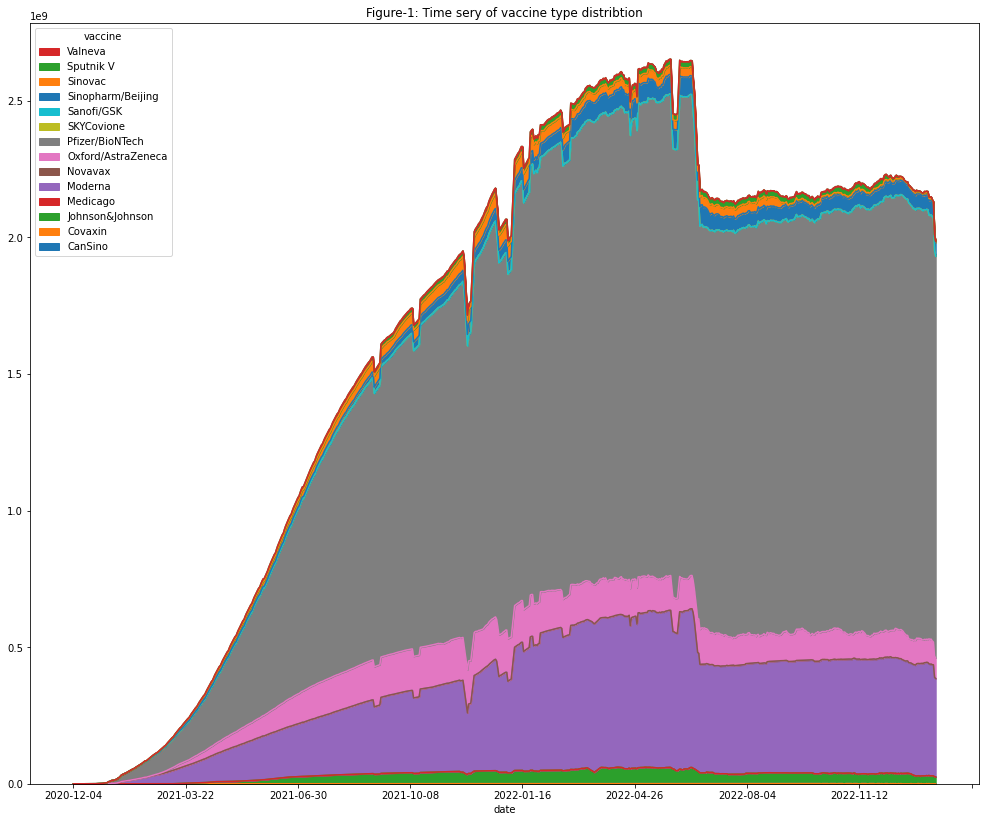

In [7]:
plot_df = vac_vol_df.copy()
plot_df.iloc[:,1:]=trim_mean(plot_df.iloc[:,1:],7,25)
plot_df.plot.area(figsize=(17,14),legend='reverse',title='Figure-1: Time sery of vaccine type distribtion')

As the Figure shows, we can estimate the popular vaccines weight as follow:
* Group 1: Non Replicating Viral Vector
    * Vaxzevria (AstraZeneca): 10
    * Ad26.COV 2-S (Janssen Pharmaceuticals): 4
    * Covishield(Serum Institute of India): 0.2 (very small)
    * Gam-Covid-Vac (Gamaleya Research Institute): 0.2 (very small)
* Group 2: RNA
    * Comirnaty (Pfizer BioNTech): 100
    * Spikevax (Moderna): 35
* Group 3: Inactivated
    * BBIBP-CorV (Beijing Bio-Institute Biological Products): 2
    * Coronavac (Sinovac): 3

**Reference:** https://covid19.trackvaccines.org/agency/who/

In [ ]:
vac_meta_df = pd.read_csv("database/Covid-19_raw_data/WHO/vaccine_meta.csv",encoding='utf-8',parse_dates=['START_DATE'])
vac_meta_df.head(3)

* <ins>Vaccine general input parameters</ins>

In [ ]:
bc_base_vaccine_percent = [1,1,1]
bc_vaccine_info = (["Non Replicating Viral Vector",56,14,14,150,150],
                   ["RNA",28,14,14,150,150],
                   ["Inactivated",28,14,14,150,150])
bc_target_priority=None
bc_vac_weight = {'Vaxzevria':(0,10),
                 'Ad26.COV 2-S':(0,4),
                 'Covishield':(0,0.2),
                 'Gam-Covid-Vac':(0,0.2),
                 'Comirnaty':(1,100),
                 'Spikevax':(1,35),
                 'BBIBP-CorV':(2,2),
                 'Coronavac':(2,3)}
bc_other_vaccine_weight = (0,0.5)


# zero for fast data processing, ignore randomness
bc_vac_method_limit = 0 
bc_vac_seed = 1

* <ins>Processing</ins>

In [ ]:
start_cell = time.perf_counter()

bc_manager = Manager()
bc_counter= bc_manager.Array('i',[0,0])
bc_time_list = bc_manager.list([])
bc_error_dict = bc_manager.dict()
bc_shared_output = bc_manager.Namespace()
bc_shared_output.shared_df = pd.DataFrame()
bc_lock = bc_manager.Lock()

#list of country iso_code
raw_processed_code = bc_processed_df.iso_code.unique()

#worker function
worker_func = partial(vaccine_wrapper_func,
                      shared_count=bc_counter,
                      time_list=bc_time_list,
                      error_dict=bc_error_dict,
                      shared_output=bc_shared_output,
                      lock=bc_lock,
                      input_data = (bc_processed_df.copy(),'iso_code'),
                      vac_meta_data=vac_meta_df,
                      vaccine_info=bc_vaccine_info,
                      base_vaccine_percent=bc_base_vaccine_percent,
                      target_priority=bc_target_priority,
                      vac_weight=bc_vac_weight,
                      other_vaccine_weight=bc_other_vaccine_weight,
                      vac_method_limit=bc_vac_method_limit,
                      vac_seed=bc_vac_seed)

executor= Pool(processes=bc_max_worker)
start_worker = time.perf_counter()
pool_result = executor.map_async(worker_func,raw_processed_code)

max_country = len(raw_processed_code)

while bc_counter[0]<max_country:
    time.sleep(1)
    n_done = bc_counter[0]
    n_wait = max_country
    total_time = round(sum(bc_time_list),2)
    if n_done!=0:
        avg_time = round(total_time/n_done,2)
    
    if n_done!=0:
        remain_country = n_wait - n_done
        remain_time = round(remain_country*avg_time,2)
        real_remain = round(remain_time/bc_max_worker,2)
    else:
        remain_country = "estimating..."
        remain_time = "-- "
        real_remain = "-- "
        
    elapsed_time = round(time.perf_counter()-start_worker,2)
    a_string = (f"Elapsed time: {elapsed_time}s    " +
                f"Total workers processing time: {total_time}s    " + 
                f" Remaining countries: {remain_country}    " + 
                f" Estimated remaining worker time: {remain_time}s    " +
                f" Estimated remaining real time: {real_remain}s")
    
    print(" "*(len(a_string)+10),end="\r")
    print(a_string,end="\r")
    
print(" "*(len(a_string)+10),end="\r")
print("---Vaccine data processing completed---")
print(f"Number of workers with error happened: {bc_counter[1]}")
print(f"Total worker processing time taken: {round(sum(bc_time_list),2)}s")

bc_processed_df = bc_shared_output.shared_df.copy()
bc_processed_df = bc_processed_df.sort_values(['iso_code','date']).reset_index(drop=True)
bc_vaccine_error_result = dict(bc_error_dict)
bc_vaccine_time = list(bc_time_list)

executor.close()
executor.join()
bc_manager.shutdown()

end_cell = time.perf_counter()
print(f"Total elapsed time on this code block: {round(end_cell-start_cell,2)}s")

* <ins>Store processed raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/WorldData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
bc_processed_df.to_csv(folder_path +"/"+"w_processed_data_by_country.csv",encoding="utf-8",index=False)
bc_processed_df.head(3)

<font size=3.5><ins>**c. Processing modeling data**</ins><a name="2.2.2.1.c"></a></font>
* <ins>Modeling general input parameters</ins>

In [ ]:
bc_r_protect_time  = 150
bc_s_vac_ratio = 3.0
bc_avg_infect_t= 1
bc_avg_death_t= 1
bc_avg_recov_t= 1
bc_avg_rotate= 1

#fill empty parameters
bc_avg_data=14
bc_weights=2
bc_include_zero=False

#reproduction number parameters
bc_p = 1.0
bc_n = 30
bc_trim = 25

* <ins>Processing</ins>

In [ ]:
counter=0
total_s=0
bc_model_input_df = bc_processed_df.copy()
bc_model_df = pd.DataFrame()
total_time_start=time.time()
for code in raw_processed_code:
    start = time.time()
    
    dummy_df = bc_model_input_df.loc[bc_model_input_df.iso_code==code].reset_index(drop=True)
    dummy_df.iloc[:,[7,8]]=dummy_df.iloc[:,[7,8]].apply(np.round)
    dummy_df[['S0','V0','I0','D0','daily_case_non_vaccinated','daily_case_vaccinated']] = model_initial(dummy_df[['case_avg','recovery_case','death_avg','curr_full_vaccinated',
                                                                                                                  'current_pol_N']].to_numpy(),
                                                                                                        bc_r_protect_time,
                                                                                                        bc_s_vac_ratio)
    dummy_df[['beta','beta_v','gamma','theta','alpha','alpha0']] = model_parameter(dummy_df[['S0','V0','I0','death_avg','recovery_case','new_full_vaccinated','new_boost_req',
                                                                                             'daily_case_non_vaccinated','daily_case_vaccinated','current_pol_N']].to_numpy(),
                                                                                    bc_r_protect_time,
                                                                                    bc_avg_infect_t,
                                                                                    bc_avg_death_t,
                                                                                    bc_avg_recov_t,
                                                                                    bc_avg_rotate)
    
    concat_df = dummy_df[['date','iso_code','continent','location','S0','V0','I0','D0','beta','beta_v','gamma','theta','alpha','alpha0',
                          'death_avg','recovery_case','new_full_vaccinated','new_boost_req','daily_case_non_vaccinated',
                          'daily_case_vaccinated','current_pol_N']].copy()
    concat_df[['S0','V0','I0','D0']]=concat_df[['S0','V0','I0','D0']].astype(np.int64)
    
    #get birth rate & death rate
    birth_rate = birth_df.loc[birth_df['ISO3 Alpha-code']==code,'Crude Birth Rate (births per 1,000 population)']
    birth_rate = (1+(float(birth_rate)/1000))**(1/365)-1
    death_rate = death_df.loc[death_df['ISO3 Alpha-code']==code,'Crude Death Rate (deaths per 1,000 population)']
    death_rate = (1+(float(death_rate)/1000))**(1/365)-1
    
    #add daily recruitment rate
    concat_df.insert(concat_df.columns.get_loc("alpha0")+1,
                            'pi',
                            ((concat_df[['S0','V0',
                                          'I0','D0']].sum(axis=1))*birth_rate
                            ).astype(np.int64))
    
    #fill empty values of each columns
    concat_df = fill_empty_param(input_df=concat_df,
                                input_col=['beta','beta_v','gamma',
                                          'theta','alpha','alpha0'],
                                avg_data=bc_avg_data,
                                weights=bc_weights,
                                include_zero=bc_include_zero)
    
    #fill remaining SVID model parameter with 0
    concat_df.iloc[:,concat_df.columns.get_loc('beta'):(concat_df.columns.get_loc('pi')+1)]=\
        concat_df.iloc[:,concat_df.columns.get_loc('beta'):(concat_df.columns.get_loc('pi')+1)].fillna(0)
    
    #calculate reproduction number
    concat_df[['daily_R0','avg_R0']]=reproduction_number(
        input_df=concat_df,
        input_col=['beta','beta_v','gamma',
                  'theta','alpha','alpha0','pi'],
        p=bc_p,
        mu=death_rate,
        n=bc_n,
        outlier_trim=bc_trim)
    
    bc_model_df = pd.concat([bc_model_df,concat_df],ignore_index=True)
    
    end=time.time()
    counter += 1
    total_s = total_s + end - start
    avg = total_s/counter
    print(f"Estimated remaining processing time: {round(avg*(raw_processed_code.shape[0]-counter),2)}s   ",end='\r')
total_time_end=time.time()
print("")
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")

* <ins>Store modeling raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/WorldData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
bc_model_df.to_csv(folder_path +"/"+"w_modeling_data_by_country.csv",encoding="utf-8",index=False)
bc_model_df.head(3)

<ins><font size=4>**2.2.2.2. By world grand total**</font></ins><a name="2.2.2.2"></a><br>
<font size=3.5><ins>**a. Processing raw data**</ins></font><a name="2.2.2.2.a"></a><br>
* <ins>Raw general input parameters</ins>

In [ ]:
w_code = 900
w_iso_code = 'OWID_WRL'

w_raw_rolling = 10
w_trim_percent = 25
w_death_distribution = [0.4,0.3,0.2,0.025,0.025,0.025,0.025]
w_death_after = 4
w_death_rolling = 14
w_use_origin = True
w_recovery_distribution = [0.3,0.5,0.1,0.05,0.05]
w_recovery_after = 7

# zero for fast data processing, ignore randomness
w_raw_method_limit=0 
w_raw_seed = 1

* <ins>Groups of function input parameters</ins>

In [ ]:
#All shouldn't be modified

w_col = ['new_cases','new_deaths']
w_window_trim = [('case_avg',w_raw_rolling,w_trim_percent),('death_avg',w_raw_rolling,w_trim_percent)]
w_date = ['date',None]
w_death_input = ('death_avg','case_avg','origin_case',w_death_distribution,{'death_after':w_death_after})
w_death_per = ('origin_case','case_avg','death_percent',w_death_rolling,w_trim_percent)
w_recov_input = ('case_avg','recovery_case',w_use_origin,w_recovery_distribution,{'recovery_after':w_recovery_after})

* <ins>Processing</ins>

In [ ]:
total_time_start = time.time()

#world average birth_rate
b_rate = birth_df.loc[birth_df['Location code']==w_code,'Crude Birth Rate (births per 1,000 population)'].values[0] 
#world average death_rate
d_rate = death_df.loc[death_df['Location code']==w_code,'Crude Death Rate (deaths per 1,000 population)'].values[0] 
population  = population_df.loc[population_df['Location code']==w_code,'Total Population, as of 1 January'].values[0]

raw_df = bc_input_df.loc[bc_input_df.iso_code==w_iso_code].copy().reset_index(drop=True)

#convert to %/day
birth_rate = (1+(b_rate/1000))**(1/365)-1 
#convert to %/day
death_rate = (1+(d_rate/1000))**(1/365)-1 
#living population which affected by the disease
total_N = (int(population),birth_rate,death_rate,'current_pol_N') 

w_processed_df = process_raw_infect_data(raw_df,
                                      w_col,
                                      w_window_trim,
                                      w_date,
                                      w_death_input,
                                      w_death_per,
                                      w_recov_input,
                                      total_N,
                                      method_limit=w_raw_method_limit,
                                      seed=w_raw_seed)

w_processed_df['new_vaccinations_smoothed'] = w_processed_df['new_vaccinations_smoothed'].interpolate(method='linear',limit_direction='forward').fillna(0).astype(np.int64)
w_processed_df[['iso_code','continent','location']] = w_processed_df[['iso_code','continent','location']].ffill().bfill()

w_processed_df = w_processed_df.iloc[w_raw_rolling-1:].reset_index(drop=True).copy() #drop ['case_avg','death_avg'] NaN rows
total_time_end = time.time()
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")
w_processed_df.head(3)

<font size=3.5><ins>**b. Processing vaccine data**</ins></font><a name="2.2.2.2.b"></a><br>
* <ins>Vaccine general input parameters</ins>

In [ ]:
w_base_vaccine_percent = [14.4,135,5]
w_vaccine_info = (["Non Replicating Viral Vector",56,14,14,150,150],
                  ["RNA",28,14,14,150,150],
                  ["Inactivated",28,14,14,150,150])
w_target_priority=None

# zero for fast data processing, ignore randomness
w_vac_method_limit = 0 
w_vac_seed = 1

* <ins>Processing</ins>

In [ ]:
total_time_start=time.time()

#vaccine type ratio will be based on current total vaccine distribution amount from Figure-1.
vac_distribute = vaccinated_case(w_base_vaccine_percent,
                                 w_vaccine_info,
                                 w_processed_df.shape[0],
                                 w_target_priority)


vac_distribute.calculate_vaccine_distribution(w_processed_df,
                                              'new_vaccinations_smoothed',
                                              method_limit=w_vac_method_limit,
                                              seed=w_vac_seed)
w_processed_df.loc[:,'curr_full_vaccinated']=vac_distribute.full_immu_matrix.sum(axis=1)
w_processed_df.loc[:,'new_full_vaccinated']=vac_distribute.new_full_matrix.sum(axis=1)
w_processed_df.loc[:,'new_boost_req']=vac_distribute.new_req_boost_matrix.sum(axis=1)
    
total_time_end=time.time()
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")

* <ins>Store processed raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/WorldData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
w_processed_df.to_csv(folder_path +"/"+"w_processed_data.csv",encoding="utf-8",index=False)
w_processed_df.head(3)

<font size=3.5><ins>**c. Processing modeling data**</ins><a name="2.2.2.2.c"></a></font>
* <ins>Modeling general input parameters</ins>

In [ ]:
w_r_protect_time  = 150
w_s_vac_ratio = 3.0
w_avg_infect_t= 1
w_avg_death_t= 1
w_avg_recov_t= 1
w_avg_rotate= 1

#fill empty parameters
w_avg_data=14
w_weights=2
w_include_zero=False

#reproduction number parameters
w_p = 1.0
w_n = 30
w_trim = 25

* <ins>Processing</ins>

In [ ]:
w_model_input_df = w_processed_df.copy()
total_time_start=time.time()

# w_model_input_df.iloc[:,[7,8]]=w_model_input_df.iloc[:,[7,8]].apply(np.ceil)
w_model_input_df.iloc[:,[7,8]]=w_model_input_df.iloc[:,[7,8]].apply(np.round)
w_model_input_df[['S0','V0','I0','D0','daily_case_non_vaccinated','daily_case_vaccinated']] = model_initial(w_model_input_df[['case_avg','recovery_case','death_avg',
                                                                                                                              'curr_full_vaccinated','current_pol_N']].to_numpy(),
                                                                                                            w_r_protect_time,
                                                                                                            w_s_vac_ratio)
w_model_input_df[['beta','beta_v','gamma','theta','alpha','alpha0']] = model_parameter(w_model_input_df[['S0','V0','I0','death_avg','recovery_case','new_full_vaccinated',
                                                                                                         'new_boost_req','daily_case_non_vaccinated','daily_case_vaccinated',
                                                                                                         'current_pol_N']].to_numpy(),
                                                                                       w_r_protect_time,
                                                                                       w_avg_infect_t,
                                                                                       w_avg_death_t,
                                                                                       w_avg_recov_t,
                                                                                       w_avg_rotate)

w_model_df = w_model_input_df[['date','iso_code','continent','location','S0','V0','I0','D0','beta','beta_v','gamma','theta','alpha','alpha0',
                               'death_avg','recovery_case','new_full_vaccinated','new_boost_req','daily_case_non_vaccinated',
                               'daily_case_vaccinated','current_pol_N']].copy()
w_model_df[['S0','V0','I0','D0']]=w_model_df[['S0','V0','I0','D0']].astype(np.int64)

#add daily recruitment rate
w_model_df.insert(w_model_df.columns.get_loc("alpha0")+1,
                        'pi',
                        ((w_model_df[['S0','V0',
                                      'I0','D0']].sum(axis=1))*birth_rate
                        ).astype(np.int64))

#fill empty values of each columns
w_model_df = fill_empty_param(input_df=w_model_df,
                            input_col=['beta','beta_v','gamma',
                                      'theta','alpha','alpha0'],
                            avg_data=w_avg_data,
                            weights=w_weights,
                            include_zero=w_include_zero)

#fill remaining SVID model parameter with 0
w_model_df.iloc[:,w_model_df.columns.get_loc('beta'):(w_model_df.columns.get_loc('pi')+1)]=\
    w_model_df.iloc[:,w_model_df.columns.get_loc('beta'):(w_model_df.columns.get_loc('pi')+1)].fillna(0)

#calculate reproduction number
w_model_df[['daily_R0','avg_R0']]=reproduction_number(
    input_df=w_model_df,
    input_col=['beta','beta_v','gamma',
              'theta','alpha','alpha0','pi'],
    p=w_p,
    mu=death_rate,
    n=w_n,
    outlier_trim=w_trim)

total_time_end=time.time()
print("Total process time taken:",round(total_time_end-total_time_start,2),"s")

* <ins>Store modeling raw data</ins>

In [ ]:
folder_path = "database/Covid-19_modeling_input/WorldData"
if os.path.exists(str(folder_path)):
    pass
else:
    os.makedirs(str(folder_path))
    print("New folder created.")
w_model_df.to_csv(folder_path +"/"+"w_modeling_data.csv",encoding="utf-8",index=False)
w_model_df.head(3)